# Challenge summary

[Challenge detail](https://trivago.zealpath.com/m/case/detail/192)

* **User Profiling team**: responsible for delivering relevant and descriptive profile of users on trivago describing user intent, which can be used to drive relevance and personalization for users of trivago

* **Goal**: predict whether or not a booking occured (binary prediction)

* **Deliverables**:
    * PDF document with answers to additional questions
    * Prediction submission csv file
    * Code for data analysis and classfication

# 0. Setting up workplace & Dataset inspection

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option("max_columns", None)

In [2]:
path = "trivago_dataset_actions_bookings/case_study_"
actions_train = pd.read_csv(path+"actions_train.csv", sep = "\t")
actions_target = pd.read_csv(path+"actions_target.csv", sep = "\t")
bookings_train = pd.read_csv(path+"bookings_train.csv", sep = "\t")
bookings_target = pd.read_csv(path+"bookings_target.csv", sep = "\t")

In [3]:
print("Shape of actions training set:",actions_train.shape)
print("Shape of actions test set:",actions_target.shape)

Shape of actions training set: (5862863, 6)
Shape of actions test set: (575152, 6)


In [4]:
print("Shape of bookings training set:",bookings_train.shape)
print("Shape of bookings test set:",bookings_target.shape)

Shape of bookings training set: (307677, 8)
Shape of bookings test set: (30128, 7)


# Data Cleaning

In [5]:
# Changing date values to datetime objects
def change_to_datetime(dt_series):
    return pd.to_datetime(dt_series, format = "%Y%m%d")

bookings_train.ymd = change_to_datetime(bookings_train.ymd)
actions_train.ymd = change_to_datetime(actions_train.ymd)
bookings_target.ymd = change_to_datetime(bookings_target.ymd)
actions_target.ymd = change_to_datetime(actions_target.ymd)

# EDA

/Users/jk6653284/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


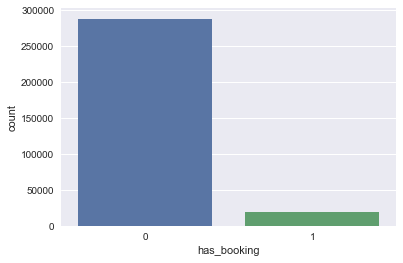

In [6]:
# Target: has_booking distribution
sns.countplot(bookings_train.has_booking)
plt.show()

The class is highly imbalanced. Class imbalance would need to be considered when making predictions, as disregarding this will give too much weight to class 0(no booking). One method can be using stratified method at the cross validation stage. Others can be explored as we go.

In [7]:
# number of unique users in the dataset
print("There are {} unique users in the bookings train dataset.".format(len(set(bookings_train.user_id))))
print("There are {} unique users in the actions train dataset.".format(len(set(actions_train.user_id))))

print("\nThere are {} unique users in the bookings target dataset.".format(len(set(bookings_target.user_id))))
print("There are {} unique users in the actions target dataset.".format(len(set(actions_target.user_id))))

There are 181860 unique users in the bookings train dataset.
There are 181730 unique users in the actions train dataset.

There are 23402 unique users in the bookings target dataset.
There are 23314 unique users in the actions target dataset.


We see that the bookings and actions dataset don't contain the same number of unique users. Since these are two different datasets, we might need to discard any users that don't have information in either of the dataset.

In [8]:
unique_btrain = set(bookings_train.user_id)
unique_atrain = set(actions_train.user_id)
unique_btarget = set(bookings_target.user_id)
unique_atarget = set(actions_target.user_id)

not_in_atrain = [i for i in unique_btrain if i not in unique_atrain]
not_in_btrain = [i for i in unique_atrain if i not in unique_btrain]
not_in_atarget = [i for i in unique_btarget if i not in unique_atarget]
not_in_btarget = [i for i in unique_atarget if i not in unique_btarget]

print('users in bookings, but not in actions training dataset:',len(not_in_atrain))
print('users in actions, but not in bookings training dataset:',len(not_in_btrain))
print('users in bookings, but not in actions target dataset:',len(not_in_atarget))
print('users in actions, but not in bookings target dataset:',len(not_in_btarget))

users in bookings, but not in actions training dataset: 130
users in actions, but not in bookings training dataset: 0
users in bookings, but not in actions target dataset: 88
users in actions, but not in bookings target dataset: 0


There are some users in the bookings for both target and training dataset that do not exist in the actions dataset. It would be interesting to see what are the characteristics of these users, though they most probably won't be able to be used in training the prediction model, as many predictor variables will be NaN.

In [9]:
# range of dates
print("bookings_train:\n",bookings_train.ymd.describe())
print("\nbookings_target:\n",bookings_target.ymd.describe())
print("\actions_train:\n",actions_train.ymd.describe())
print("\actions_target:\n",actions_target.ymd.describe())

bookings_train:
 count                  307677
unique                     27
top       2017-04-03 00:00:00
freq                    13214
first     2017-04-01 00:00:00
last      2017-04-27 00:00:00
Name: ymd, dtype: object

bookings_target:
 count                   30128
unique                      3
top       2017-04-30 00:00:00
freq                    10690
first     2017-04-28 00:00:00
last      2017-04-30 00:00:00
Name: ymd, dtype: object
ctions_train:
 count                 5862863
unique                     27
top       2017-04-03 00:00:00
freq                   251892
first     2017-04-01 00:00:00
last      2017-04-27 00:00:00
Name: ymd, dtype: object
ctions_target:
 count                  575152
unique                      3
top       2017-04-30 00:00:00
freq                   201916
first     2017-04-28 00:00:00
last      2017-04-30 00:00:00
Name: ymd, dtype: object


The whole dataset contains one month data information for April, where the training set includes date up until the 27th, and the test set includes date until the 30th.

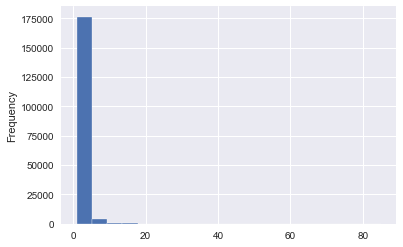

count    181860.000000
mean          1.691834
std           1.880178
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          85.000000
Name: session_id, dtype: float64


In [10]:
# how many sessions do people usually go through?
bookings_train.groupby("user_id").session_id.count().plot.hist(ec = 'white', bins = 20)
plt.show()
print(bookings_train.groupby("user_id").session_id.count().describe())

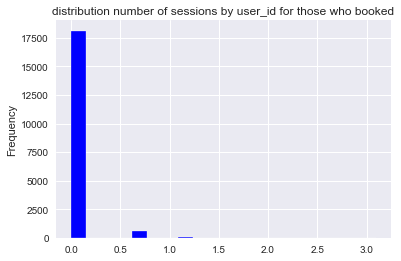

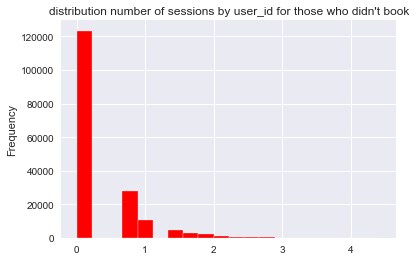

distribution number of sessions by user_id for those who booked:
count    18793.000000
mean         1.045442
std          0.316900
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         22.000000
Name: session_id, dtype: float64

distribution number of sessions by user_id for those who didn't book:
count    173730.000000
mean          1.657917
std           1.833621
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max          85.000000
Name: session_id, dtype: float64


In [11]:
# is there a huge difference in that number for those who booked and those who did not?
bookings_train[bookings_train.has_booking == 1].groupby("user_id").session_id.count().apply(lambda x: np.log(x)).plot.hist(ec = 'white', bins = 20, color = 'blue')
plt.title("distribution number of sessions by user_id for those who booked")
plt.show()
bookings_train[bookings_train.has_booking == 0].groupby("user_id").session_id.count().apply(lambda x: np.log(x)).plot.hist(ec = 'white', bins = 20, color = 'red')
plt.title("distribution number of sessions by user_id for those who didn't book")
plt.show()

print("distribution number of sessions by user_id for those who booked:")
print(bookings_train[bookings_train.has_booking == 1].groupby("user_id").session_id.count().describe())
print("\ndistribution number of sessions by user_id for those who didn't book:")
print(bookings_train[bookings_train.has_booking == 0].groupby("user_id").session_id.count().describe())

In [13]:
# traffic type by app or not
bookings_train.groupby("is_app")["traffic_type"].value_counts()

is_app  traffic_type
0       2               89600
        1               88212
        6               60570
        4               25675
        3               19675
        10                706
        7                 603
1       1               22636
Name: traffic_type, dtype: int64

Since 'is_app' variable with value 1 has only 1 traffic type (1), I think it's safe to assume that this is the 'direct' access traffic.

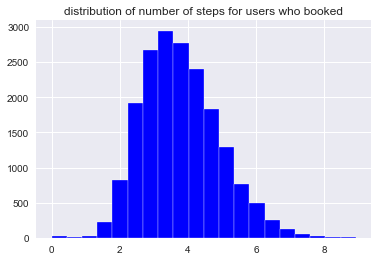

count    18702.000000
mean        95.364613
std        221.230447
min          1.000000
25%         19.000000
50%         40.000000
75%         90.750000
max       7560.000000
Name: step, dtype: float64


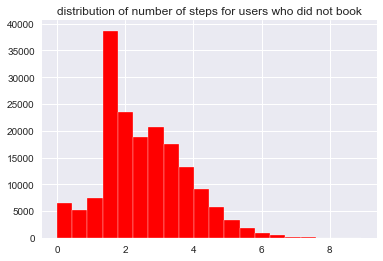

count    173686.000000
mean         32.020779
std         100.029040
min           1.000000
25%           4.000000
50%          11.000000
75%          28.000000
max        7560.000000
Name: step, dtype: float64


In [15]:
# number of steps distribution
actions_train[actions_train.user_id.isin(np.unique(bookings_train.loc[bookings_train["has_booking"] == 1, 'user_id']))].groupby("user_id")['step'].count().apply(lambda x: np.log(x)).hist(ec = 'white', bins = 20,
                                                                                                                                  color = 'blue')
plt.title("distribution of number of steps for users who booked")
plt.show()
print(actions_train[actions_train.user_id.isin(np.unique(bookings_train.loc[bookings_train["has_booking"] == 1, 'user_id']))].groupby("user_id")['step'].count().describe())

actions_train[actions_train.user_id.isin(np.unique(bookings_train.loc[bookings_train["has_booking"] == 0, 'user_id']))].groupby("user_id")['step'].count().apply(lambda x: np.log(x)).hist(ec = 'white', bins = 20,
                                                                                                                                   color = 'red')
plt.title("distribution of number of steps for users who did not book")
plt.show()
print(actions_train[actions_train.user_id.isin(np.unique(bookings_train.loc[bookings_train["has_booking"] == 0, 'user_id']))].groupby("user_id")['step'].count().describe())

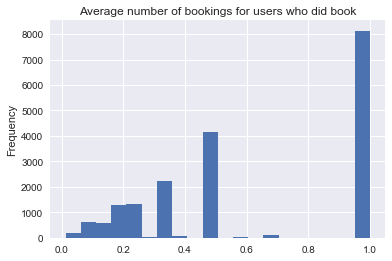

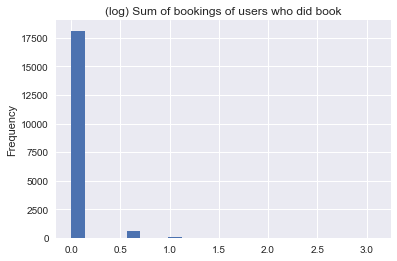

In [19]:
bookings_train.groupby("user_id")['has_booking'].mean()[bookings_train.groupby("user_id")['has_booking'].mean() > 0.0].plot.hist(bins = 20)
plt.title("Average number of bookings for users who did book")
plt.show()

bookings_train.groupby("user_id")['has_booking'].sum()[bookings_train.groupby("user_id")['has_booking'].sum() > 0.0].apply(lambda x : np.log(x)).plot.hist(bins = np.max(bookings_train.groupby("user_id")['has_booking'].sum()))
plt.title("(log) Sum of bookings of users who did book")
plt.show()


In [55]:
# action ids
# action_id 2142 has more than twice as many records as the next most common action_id for both train and target dataset

print("Top 10 action id in training set:\n")
print(actions_train.action_id.value_counts()[:10])
print("\nTop 10 action id in test set:\n")
print(actions_target.action_id.value_counts()[:10])

Top 10 action id in training set:

2142    1150642
2113     689437
8001     343534
2116     278855
6999     253549
2111     180022
2371     156456
2119     145060
2358     138146
2503     135171
Name: action_id, dtype: int64

Top 10 action id in test set:

2142    114308
2113     64011
8001     31541
2116     29305
6999     24694
2111     17011
2119     13645
2371     13333
2503     13290
2358     12650
Name: action_id, dtype: int64


In [58]:
actions_train[actions_train.action_id == 2142]

,ymd,user_id,session_id,action_id,reference,step,dayofweek,weekend,unique_reference,reference_length
76,2017-04-19,1607565913119260,5462519157199531712,2142,359221,24,2,0,0,6
78,2017-04-19,1607565913119260,5462519157199531712,2142,359221,26,2,0,0,6
79,2017-04-19,1607565913119260,5462519157199531712,2142,359221,27,2,0,0,6
80,2017-04-19,1607565913119260,5462519157199531712,2142,359221,28,2,0,0,6
81,2017-04-19,1607565913119260,5462519157199531712,2142,359221,29,2,0,0,6
82,2017-04-19,1607565913119260,5462519157199531712,2142,944775,30,2,0,0,6
144,2017-04-16,2413031573758500,6317573206950631304,2142,1483495,32,6,1,0,7
145,2017-04-16,2413031573758500,6317573206950631304,2142,1483495,33,6,1,0,7
146,2017-04-16,2413031573758500,6317573206950631304,2142,1483495,34,6,1,0,7
147,2017-04-16,2413031573758500,6317573206950631304,2142,1483495,35,6,1,0,7


# Feature Engineering

In [20]:
# we don't know the time of the sessions, but we can definitely see whether or not the date was a weekend or not
# new variable with dayofweek where Monday = 0, and Sunday = 6
bookings_train['dayofweek'] = bookings_train.ymd.dt.dayofweek
bookings_target['dayofweek'] = bookings_target.ymd.dt.dayofweek
actions_train['dayofweek'] = actions_train.ymd.dt.dayofweek
actions_target['dayofweek'] = actions_target.ymd.dt.dayofweek

# new variable whether or not the day is weekend
bookings_train['weekend'] = [1 if i in [5,6] else 0 for i in bookings_train.dayofweek]
bookings_target['weekend'] = [1 if i in [5,6] else 0 for i in bookings_target.dayofweek]
actions_train['weekend'] = [1 if i in [5,6] else 0 for i in actions_train.dayofweek]
actions_target['weekend'] = [1 if i in [5,6] else 0 for i in actions_target.dayofweek]

/Users/jk6653284/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


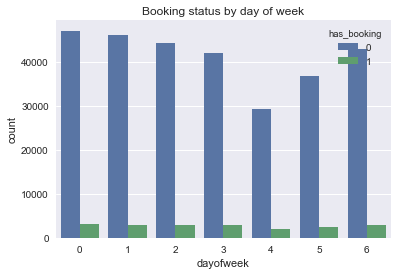

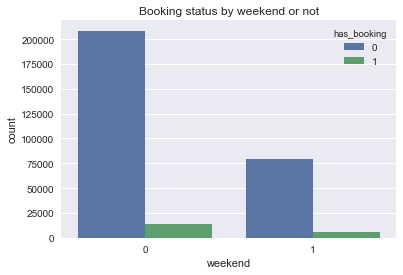

In [21]:
# see distribution of bookings by day of week
sns.countplot(bookings_train.dayofweek, hue = bookings_train.has_booking)
plt.title("Booking status by day of week")
plt.show()
sns.countplot(bookings_train.weekend, hue = bookings_train.has_booking)
plt.title("Booking status by weekend or not")
plt.show()

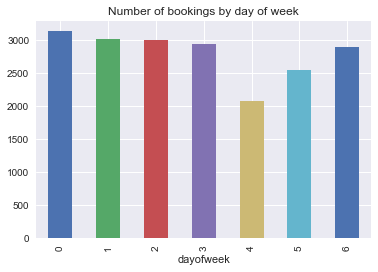

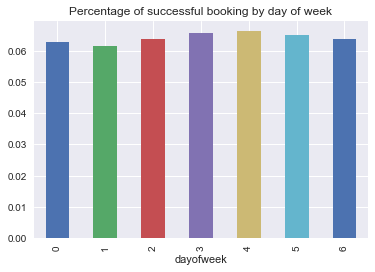

In [22]:
# count by day of week
bookings_train.groupby("dayofweek")['has_booking'].sum().plot.bar()
plt.title("Number of bookings by day of week")
plt.show()
bookings_train.groupby("dayofweek")['has_booking'].mean().plot.bar()
plt.title("Percentage of successful booking by day of week")
plt.show()

While the absolute number of bookings is lower on Friday, the percentage of booking from all bookings is actually the highest on Friday. We can probably suspect that a lot of people browse during other weeks, but on Friday, there are quite a lot of last minute booking before the weekend trip.

## Putting it all together

The final prediction is based on bookings dataset, and as mentioned, the unique users are not the same as in the action set as in the booking set. Luckily, all the users that are in actions are also apparent in bookings too. Thus, we transfer columns of actions to bookings.

In [23]:
# things to transfer to bookings_train
# in bookings there is only a single session_id - thus it makes sense to transfer whatever is in the action data
# grouped by the session_id

# step: count steps (number of steps)
steps_train = pd.DataFrame({'session_id': np.unique(actions_train.session_id),
              'steps_total': actions_train.groupby("session_id")['step'].count().values})
steps_target = pd.DataFrame({'session_id': np.unique(actions_target.session_id),
              'steps_total': actions_target.groupby("session_id")['step'].count().values})

In [24]:
# reference counts
print(actions_train.reference.value_counts().describe())

count    121528.000000
mean         48.242899
std        3203.718025
min           1.000000
25%           1.000000
50%           4.000000
75%          16.000000
max      904424.000000
Name: reference, dtype: float64


Most of the objects are unique to each each session and user. up to 25% of the references are only used once. There are also more generic ones on the other extreme, where the count is as big as 904424. In general though, the reference seem to be targted or unique to session. We can create 2 possible variables from reference: one is the uniqueness of reference (only 1 per action or session), and the other is content-related or function-related action (as indicated by the document). The only problem with the 2nd variable is that we need to assume that all big numbers are content-related, and that we need to set an arbitrary 'big' number that sets the difference.


Length of reference + whether or not it is 1?

In [25]:
# unique reference or not?
actions_train['unique_reference'] = [1 if i == 1 else 0 for i in actions_train.reference]
actions_target['unique_reference'] = [1 if i == 1 else 0 for i in actions_target.reference]

# length of reference number: long ones should be function related, and short ones should be content-related, 
# but this way we can get a way setting an arbitrary set point
# hopefully this will reveal some information
actions_train['reference_length'] = [len(str(i)) for i in actions_train.reference]
actions_target['reference_length'] = [len(str(i)) for i in actions_target.reference]

In [26]:
actions_train.head()

,ymd,user_id,session_id,action_id,reference,step,dayofweek,weekend,unique_reference,reference_length
0,2017-04-23,388309106223940,3052767322364990735,8001,1323836,1,6,1,0,7
1,2017-04-10,452426828488840,1022778951418899936,2116,929835,1,0,0,0,6
2,2017-04-10,452426828488840,1022778951418899936,6999,0,2,0,0,0,1
3,2017-04-10,452426828488840,1022778951418899936,2116,929835,3,0,0,0,6
4,2017-04-10,452426828488840,1022778951418899936,2503,1,4,0,0,1,1


In [27]:
bookings_train.head()

,ymd,user_id,session_id,referer_code,is_app,agent_id,traffic_type,has_booking,dayofweek,weekend
0,2017-04-23,388309106223940,3052767322364990735,0,0,2,1,0,6,1
1,2017-04-10,452426828488840,1022778951418899936,0,0,10,2,0,0,0
2,2017-04-15,452426828488840,4191504489082712531,0,0,10,2,0,5,1
3,2017-04-06,819438352219100,4560227804862289210,1,0,1,1,0,3,0
4,2017-04-07,1113732603712480,4115013282086590434,0,0,9,2,0,4,0


In [28]:
# count of each reference length
# this would contain more information than aggregating with a single mean or mode number

# training data
stacked_train = pd.pivot_table(data = actions_train, columns = ['session_id', 'reference_length'],values = ['step'], aggfunc = [len]).stack().reset_index()[['session_id', 'reference_length', 0]]
stacked_train.columns = ['session_id', 'reference_length', 'count']
length_count_train = stacked_train.pivot_table(index = "session_id", columns = 'reference_length', values = 'count').reset_index()
length_count_train.columns = ['session_id']+['reference_length_'+str(i) for i in range(1,10)]
length_count_train.fillna(0, inplace = True)

# target data
stacked_target = pd.pivot_table(data = actions_target, columns = ['session_id', 'reference_length'],values = ['step'], aggfunc = [len]).stack().reset_index()[['session_id', 'reference_length', 0]]
stacked_target.columns = ['session_id', 'reference_length', 'count']
length_count_target = stacked_target.pivot_table(index = "session_id", columns = 'reference_length', values = 'count').reset_index()
length_count_target.columns = ['session_id']+['reference_length_'+str(i) for i in range(1,10)]
length_count_target.fillna(0, inplace = True)


In [29]:
# new dataframes to be added to bookings dataset
actions_merged_train = pd.merge(steps_train, length_count_train, on='session_id')
actions_merged_target = pd.merge(steps_target, length_count_target, on='session_id')

# merge with bookings data, making a left join on bookings data
bookings_train_full = pd.merge(bookings_train, actions_merged_train, on = 'session_id', how = 'left')
bookings_target_full = pd.merge(bookings_target, actions_merged_target, on = 'session_id', how = 'left')

# reset index
bookings_train_full.reset_index(drop = 'True', inplace = True)
bookings_target.reset_index(drop = 'True', inplace = True)

As seen before, because bookings dataset has some users and session id that don't exist in the actions dataset, there are going to be some missing values. We would need to impute them in some way. Because 0 is a valid value in this case, it would not be wise to simply impute null values with 0.

In [30]:
# look at null values
print("missing data in full training data:")
print(bookings_train_full.isnull().sum()[bookings_train_full.isnull().sum() > 0])
print("\nmissing data in full test data:")
print(bookings_target_full.isnull().sum()[bookings_train_full.isnull().sum() > 0])

missing data in full training data:
steps_total           1571
reference_length_1    1571
reference_length_2    1571
reference_length_3    1571
reference_length_4    1571
reference_length_5    1571
reference_length_6    1571
reference_length_7    1571
reference_length_8    1571
reference_length_9    1571
dtype: int64

missing data in full test data:
steps_total           171
reference_length_1    171
reference_length_2    171
reference_length_3    171
reference_length_4    171
reference_length_5    171
reference_length_6    171
reference_length_7    171
reference_length_8    171
reference_length_9    171
dtype: int64


In [31]:
# imputing missing values with KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
empty_df = pd.DataFrame()

# missing value columns
missing_cols = bookings_train_full.isnull().sum()[bookings_train_full.isnull().sum() > 0].index.tolist()
missing_cols.append('ymd')
missing_cols.append('has_booking')
bookings_train_full.head()

# create separate dataframe with only features
train_X = scaler.fit_transform(bookings_train_full.dropna(axis = 0).drop(missing_cols, axis = 1))
test_X = scaler.fit_transform(bookings_train_full[bookings_train_full.steps_total.isnull()].drop(missing_cols, axis = 1))
missing_cols.remove('ymd')
missing_cols.remove('has_booking')
for i in missing_cols:
    train_y = bookings_train_full.dropna(axis = 0)[i]
    pred = KNeighborsClassifier(3).fit(train_X, train_y).predict(test_X)
    empty_df[i] = pred

for i in missing_cols:
    bookings_train_full.loc[bookings_train_full[i].isnull(),i] = empty_df[i].tolist()

In [32]:
# same for test
scaler = RobustScaler()
empty_df = pd.DataFrame()

# missing value columns
missing_cols = bookings_target_full.isnull().sum()[bookings_target_full.isnull().sum() > 0].index.tolist()
missing_cols.append('ymd')
bookings_target_full.head()

# create separate dataframe with only features
train_X = scaler.fit_transform(bookings_target_full.dropna(axis = 0).drop(missing_cols, axis = 1))
test_X = scaler.fit_transform(bookings_target_full[bookings_target_full.steps_total.isnull()].drop(missing_cols, axis = 1))
missing_cols.remove('ymd')
for i in missing_cols:
    train_y = bookings_target_full.dropna(axis = 0)[i]
    pred = KNeighborsClassifier(3).fit(train_X, train_y).predict(test_X)
    empty_df[i] = pred

# fill in with empty value
for i in missing_cols:
    bookings_target_full.loc[bookings_target_full[i].isnull(),i] = empty_df[i].tolist()

In [33]:
# check for null values
print("training missing values:")
print(bookings_train_full.isnull().sum()[bookings_train_full.isnull().sum() > 0])
print("\ntest missing values:")
print(bookings_target_full.isnull().sum()[bookings_target_full.isnull().sum() > 0])

training missing values:
Series([], dtype: int64)

test missing values:
Series([], dtype: int64)


## Feature transformation

In [34]:
bookings_train_full.head()

,ymd,user_id,session_id,referer_code,is_app,agent_id,traffic_type,has_booking,dayofweek,weekend,steps_total,reference_length_1,reference_length_2,reference_length_3,reference_length_4,reference_length_5,reference_length_6,reference_length_7,reference_length_8,reference_length_9
0,2017-04-23,388309106223940,3052767322364990735,0,0,2,1,0,6,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,2017-04-10,452426828488840,1022778951418899936,0,0,10,2,0,0,0,5.0,2.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
2,2017-04-15,452426828488840,4191504489082712531,0,0,10,2,0,5,1,3.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
3,2017-04-06,819438352219100,4560227804862289210,1,0,1,1,0,3,0,33.0,16.0,2.0,0.0,0.0,13.0,2.0,0.0,0.0,0.0
4,2017-04-07,1113732603712480,4115013282086590434,0,0,9,2,0,4,0,11.0,1.0,2.0,2.0,0.0,0.0,5.0,1.0,0.0,0.0


In [113]:
# make all categorical variables as object type variable
cat_cols = ['referer_code','agent_id', 'traffic_type', 'dayofweek']

bookings_train_full[cat_cols] = bookings_train_full[cat_cols].astype(object)
bookings_target_full[cat_cols] = bookings_target_full[cat_cols].astype(object)

In [114]:
# dummify categorical variables
# keep id
train_session_id = bookings_train_full.session_id
target_session_id = bookings_target_full.session_id

# put together and dummify
full_dummy = pd.get_dummies(pd.concat([bookings_train_full, bookings_target_full]))

In [141]:
# training set and test set
# divide between train and test set again
train_dummy = full_dummy[:len(bookings_train_full)]
target_dummy = full_dummy[len(bookings_train_full):]

X_train = train_dummy.drop(['ymd', 'user_id', 'session_id','has_booking'], axis = 1)
y_train = train_dummy.has_booking
X_test = target_dummy.drop(['ymd', 'user_id', 'session_id', 'has_booking'], axis = 1)

# Modeling

## Approaches

While the ultimate question is answering yes or no to booking status, I think for this classification task, it is more interesting to use a generative model rather than a deterministic one, since if we know the probability a user (or session) will be belonging to class 1 or 0, then from there we can try to uncover how do high probability and low probability people differ within the same group. If there is some insight there, we can use that to try further techniques to encourage booking (for different stages of action for example).

## Baseline models

### Logistic regression baseline

In [38]:
# import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import matthews_corrcoef

In [39]:
# initiate logisticregression and cross validation method with stratifiedkfold
lr = LogisticRegression()
skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# define error metrics function
def mcc(y_true, y_pred): 
    return matthews_corrcoef(y_true, y_pred)

# transform X_train
X_train_transformed = RobustScaler().fit_transform(X_train)

# build baseline model
# lr_baseline = make_pipeline(RobustScaler(), lr).fit(X = X_train, y = y_train)
lr_baseline_cv = cross_val_score(lr, X_train_transformed, y_train,
                                scoring = 'roc_auc', cv = skfolds, verbose = 5)

[CV]  ................................................................
[CV] ....................... , score=0.7479363190097441, total=   4.5s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.6s remaining:    0.0s


[CV] ....................... , score=0.7527941807729774, total=   3.8s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.4s remaining:    0.0s


[CV] ....................... , score=0.7499862216884859, total=   4.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   12.5s remaining:    0.0s


[CV] ....................... , score=0.7559180973864754, total=   4.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   16.8s remaining:    0.0s


[CV] ....................... , score=0.7493719855773839, total=   4.2s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   21.0s finished


In [40]:
print("Baseline mean score:", lr_baseline_cv.mean())

Baseline mean score: 0.7512013608870134


The roc_auc score for the baseline model (existing features + some new features + logistic regression without tuning) is 0.75.

### Random Forest

In [41]:
from sklearn.ensemble import RandomForestClassifier

# initiate randomforest classifier and cross validation method with stratifiedkfold
rf = RandomForestClassifier()
skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# transform X_train
X_train_transformed = RobustScaler().fit_transform(X_train)

# build baseline model
rf_baseline_cv = cross_val_score(rf, X_train_transformed, y_train,
                                scoring = 'roc_auc', cv = skfolds, verbose = 5)

[CV]  ................................................................
[CV] ....................... , score=0.6997446724829608, total=   4.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.4s remaining:    0.0s


[CV] ....................... , score=0.7016251509883892, total=   4.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.0s remaining:    0.0s


[CV] ....................... , score=0.6993220602400593, total=   4.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   13.3s remaining:    0.0s


[CV] ....................... , score=0.7025391048893084, total=   4.4s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   17.7s remaining:    0.0s


[CV] ....................... , score=0.6980141257980121, total=   4.5s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.3s finished


In [42]:
rf_baseline_cv.mean()

0.700249022879746

### XGBoost Classifier

In [60]:
from xgboost import XGBClassifier

# initiate classifier
xgb = XGBClassifier()
skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# build baseline model
xgb_baseline_cv = cross_val_score(xgb, X_train_transformed, y_train,
                                 scoring = 'roc_auc', cv = skfolds, verbose = 5)

[CV]  ................................................................
[CV] ....................... , score=0.8075904192196548, total=  42.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   43.0s remaining:    0.0s


[CV] ....................... , score=0.8087575165118773, total=  41.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s


[CV] ....................... , score=0.8027782894847241, total=  41.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.1min remaining:    0.0s


[CV] ....................... , score=0.8056252018974402, total=  44.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  2.8min remaining:    0.0s


[CV] ........................ , score=0.803222975265746, total=  40.5s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.5min finished


In [61]:
xgb_baseline_cv.mean()

0.8055948804758885

### Light GBM

In [65]:
from lightgbm import LGBMClassifier

# initiate MLP classifier
lgb = LGBMClassifier()

# build baseline model
lgb_baseline_cv = cross_val_score(lgb, X_train_transformed, y_train,
                                 scoring = 'roc_auc', cv = skfolds, verbose = 5)

[CV]  ................................................................
[CV] ....................... , score=0.8215464859602994, total=   2.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.7s remaining:    0.0s


[CV] ....................... , score=0.8226925047300788, total=   2.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    5.3s remaining:    0.0s


[CV] ....................... , score=0.8178516429884275, total=   2.6s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    8.0s remaining:    0.0s


[CV] ....................... , score=0.8188933027791931, total=   2.7s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   10.7s remaining:    0.0s


[CV] ....................... , score=0.8160232586204668, total=   2.5s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   13.2s finished


In [66]:
lgb_baseline_cv.mean()

0.8194014390156932

### Neurnal network (Multi perceptron classifier)

In [43]:
from sklearn.neural_network import MLPClassifier

# initiate MLP classifier and cross validation method with stratifiedkfold
mlp = MLPClassifier()
skfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# transform X_train
X_train_transformed = RobustScaler().fit_transform(X_train)

# build baseline model
mlp_baseline_cv = cross_val_score(mlp, X_train_transformed, y_train,
                                scoring = 'roc_auc', cv = skfolds, verbose = 5)

[CV]  ................................................................
[CV] ....................... , score=0.8139145899330709, total=  58.1s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   58.2s remaining:    0.0s


[CV] ....................... , score=0.8154220576577981, total=  27.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.4min remaining:    0.0s


[CV] ....................... , score=0.8112569039237565, total=  47.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.2min remaining:    0.0s


[CV] ....................... , score=0.8106311428084588, total=  58.3s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  3.2min remaining:    0.0s


[CV] ....................... , score=0.8079641083843647, total=  45.0s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  3.9min finished


In [44]:
mlp_baseline_cv.mean()

0.8118377605414897

### Baseline model accuracy summary

In [100]:
rocauc_scores = pd.DataFrame(columns = ['model', 'baseline_mean_CV_score'])
rocauc_scores.loc[0, :] = ['logistic regression', lr_baseline_cv.mean()]
rocauc_scores.loc[1, :] = ['random forest classifier', rf_baseline_cv.mean()]
rocauc_scores.loc[2, :] = ['xgboost classifier', xgb_baseline_cv.mean()]
rocauc_scores.loc[3, :] = ['light GBM classifier', lgb_baseline_cv.mean()]
rocauc_scores.loc[4, :] = ['MLP Classifier', mlp_baseline_cv.mean()]
rocauc_scores.sort_values('baseline_mean_CV_score', ascending = False)

,model,baseline_mean_CV_score
3,light GBM classifier,0.819401
4,MLP Classifier,0.811838
2,xgboost classifier,0.805595
0,logistic regression,0.751201
1,random forest classifier,0.700249


## Tuned models

In [86]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

### Light GBM tuned

In [80]:
# hyperparameter tuning
lgb_random = RandomizedSearchCV(lgb, param_distributions = {
    'num_leaves': [10, 20, 40],
    'learning_rate': [0.3, 0.1, 0.01],
    'boosting_type': ['gbdt', 'dart']
},
                               cv = skfolds, verbose = 5, random_state = 42, n_jobs = 1)

# fit random search CV
lgb_random.fit(X_train_transformed, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] num_leaves=10, learning_rate=0.3, boosting_type=gbdt ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s


[CV]  num_leaves=10, learning_rate=0.3, boosting_type=gbdt, score=0.9360861934477379, total=   1.5s
[CV] num_leaves=10, learning_rate=0.3, boosting_type=gbdt ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.5s remaining:    0.0s


[CV]  num_leaves=10, learning_rate=0.3, boosting_type=gbdt, score=0.9360211908476339, total=   1.5s
[CV] num_leaves=10, learning_rate=0.3, boosting_type=gbdt ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    5.2s remaining:    0.0s


[CV]  num_leaves=10, learning_rate=0.3, boosting_type=gbdt, score=0.9359063947347038, total=   1.5s
[CV] num_leaves=10, learning_rate=0.3, boosting_type=gbdt ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    7.1s remaining:    0.0s


[CV]  num_leaves=10, learning_rate=0.3, boosting_type=gbdt, score=0.9359551474770456, total=   1.5s
[CV] num_leaves=10, learning_rate=0.3, boosting_type=gbdt ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  num_leaves=10, learning_rate=0.3, boosting_type=gbdt, score=0.9359713983911595, total=   1.5s
[CV] num_leaves=20, learning_rate=0.3, boosting_type=gbdt ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  num_leaves=20, learning_rate=0.3, boosting_type=gbdt, score=0.9359886895475819, total=   1.8s
[CV] num_leaves=20, learning_rate=0.3, boosting_type=gbdt ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  num_leaves=20, learning_rate=0.3, boosting_type=gbdt, score=0.9356636765470618, total=   1.9s
[CV] num_leaves=20, learning_rate=0.3, boosting_type=gbdt ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  num_leaves=20, learning_rate=0.3, boosting_type=gbdt, score=0.9359063947347038, total=   2.3s
[CV] num_leaves=20, learning_rate=0.3, boosting_type=gbdt ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  num_leaves=20, learning_rate=0.3, boosting_type=gbdt, score=0.9354351182254002, total=   2.1s
[CV] num_leaves=20, learning_rate=0.3, boosting_type=gbdt ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  num_leaves=20, learning_rate=0.3, boosting_type=gbdt, score=0.9354351182254002, total=   2.3s
[CV] num_leaves=40, learning_rate=0.01, boosting_type=gbdt ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  num_leaves=40, learning_rate=0.01, boosting_type=gbdt, score=0.9361349453978159, total=   3.6s
[CV] num_leaves=40, learning_rate=0.01, boosting_type=gbdt ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  num_leaves=40, learning_rate=0.01, boosting_type=gbdt, score=0.9361349453978159, total=   3.5s
[CV] num_leaves=40, learning_rate=0.01, boosting_type=gbdt ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  num_leaves=40, learning_rate=0.01, boosting_type=gbdt, score=0.9361501584464126, total=   3.3s
[CV] num_leaves=40, learning_rate=0.01, boosting_type=gbdt ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  num_leaves=40, learning_rate=0.01, boosting_type=gbdt, score=0.9361176566181848, total=   3.3s
[CV] num_leaves=40, learning_rate=0.01, boosting_type=gbdt ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  num_leaves=40, learning_rate=0.01, boosting_type=gbdt, score=0.9361501584464126, total=   3.1s
[CV] num_leaves=40, learning_rate=0.1, boosting_type=gbdt ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  num_leaves=40, learning_rate=0.1, boosting_type=gbdt, score=0.9360536921476859, total=   2.7s
[CV] num_leaves=40, learning_rate=0.1, boosting_type=gbdt ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  num_leaves=40, learning_rate=0.1, boosting_type=gbdt, score=0.9361511960478419, total=   3.1s
[CV] num_leaves=40, learning_rate=0.1, boosting_type=gbdt ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  num_leaves=40, learning_rate=0.1, boosting_type=gbdt, score=0.9361664093605265, total=   3.3s
[CV] num_leaves=40, learning_rate=0.1, boosting_type=gbdt ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  num_leaves=40, learning_rate=0.1, boosting_type=gbdt, score=0.9361176566181848, total=   3.4s
[CV] num_leaves=40, learning_rate=0.1, boosting_type=gbdt ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  num_leaves=40, learning_rate=0.1, boosting_type=gbdt, score=0.9361826602746405, total=   2.9s
[CV] num_leaves=10, learning_rate=0.1, boosting_type=gbdt ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  num_leaves=10, learning_rate=0.1, boosting_type=gbdt, score=0.9361349453978159, total=   1.6s
[CV] num_leaves=10, learning_rate=0.1, boosting_type=gbdt ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  num_leaves=10, learning_rate=0.1, boosting_type=gbdt, score=0.9361349453978159, total=   1.8s
[CV] num_leaves=10, learning_rate=0.1, boosting_type=gbdt ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  num_leaves=10, learning_rate=0.1, boosting_type=gbdt, score=0.9361501584464126, total=   1.8s
[CV] num_leaves=10, learning_rate=0.1, boosting_type=gbdt ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  num_leaves=10, learning_rate=0.1, boosting_type=gbdt, score=0.9361501584464126, total=   1.8s
[CV] num_leaves=10, learning_rate=0.1, boosting_type=gbdt ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  num_leaves=10, learning_rate=0.1, boosting_type=gbdt, score=0.9361501584464126, total=   1.8s
[CV] num_leaves=20, learning_rate=0.1, boosting_type=dart ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  num_leaves=20, learning_rate=0.1, boosting_type=dart, score=0.9361349453978159, total=   4.0s
[CV] num_leaves=20, learning_rate=0.1, boosting_type=dart ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  num_leaves=20, learning_rate=0.1, boosting_type=dart, score=0.9361349453978159, total=   4.2s
[CV] num_leaves=20, learning_rate=0.1, boosting_type=dart ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  num_leaves=20, learning_rate=0.1, boosting_type=dart, score=0.9361501584464126, total=   4.1s
[CV] num_leaves=20, learning_rate=0.1, boosting_type=dart ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  num_leaves=20, learning_rate=0.1, boosting_type=dart, score=0.9361501584464126, total=   3.9s
[CV] num_leaves=20, learning_rate=0.1, boosting_type=dart ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  num_leaves=20, learning_rate=0.1, boosting_type=dart, score=0.9361501584464126, total=   3.8s
[CV] num_leaves=20, learning_rate=0.01, boosting_type=dart ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  num_leaves=20, learning_rate=0.01, boosting_type=dart, score=0.9361349453978159, total=   3.5s
[CV] num_leaves=20, learning_rate=0.01, boosting_type=dart ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  num_leaves=20, learning_rate=0.01, boosting_type=dart, score=0.9361349453978159, total=   3.7s
[CV] num_leaves=20, learning_rate=0.01, boosting_type=dart ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  num_leaves=20, learning_rate=0.01, boosting_type=dart, score=0.9361501584464126, total=   3.7s
[CV] num_leaves=20, learning_rate=0.01, boosting_type=dart ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  num_leaves=20, learning_rate=0.01, boosting_type=dart, score=0.9361501584464126, total=   3.7s
[CV] num_leaves=20, learning_rate=0.01, boosting_type=dart ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  num_leaves=20, learning_rate=0.01, boosting_type=dart, score=0.9361501584464126, total=   3.6s
[CV] num_leaves=10, learning_rate=0.01, boosting_type=dart ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  num_leaves=10, learning_rate=0.01, boosting_type=dart, score=0.9361349453978159, total=   2.6s
[CV] num_leaves=10, learning_rate=0.01, boosting_type=dart ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  num_leaves=10, learning_rate=0.01, boosting_type=dart, score=0.9361349453978159, total=   2.9s
[CV] num_leaves=10, learning_rate=0.01, boosting_type=dart ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  num_leaves=10, learning_rate=0.01, boosting_type=dart, score=0.9361501584464126, total=   2.7s
[CV] num_leaves=10, learning_rate=0.01, boosting_type=dart ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  num_leaves=10, learning_rate=0.01, boosting_type=dart, score=0.9361501584464126, total=   3.0s
[CV] num_leaves=10, learning_rate=0.01, boosting_type=dart ...........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  num_leaves=10, learning_rate=0.01, boosting_type=dart, score=0.9361501584464126, total=   2.9s
[CV] num_leaves=40, learning_rate=0.3, boosting_type=dart ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  num_leaves=40, learning_rate=0.3, boosting_type=dart, score=0.9362324492979719, total=   5.3s
[CV] num_leaves=40, learning_rate=0.3, boosting_type=dart ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  num_leaves=40, learning_rate=0.3, boosting_type=dart, score=0.9361511960478419, total=   5.6s
[CV] num_leaves=40, learning_rate=0.3, boosting_type=dart ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  num_leaves=40, learning_rate=0.3, boosting_type=dart, score=0.9361826602746405, total=   4.8s
[CV] num_leaves=40, learning_rate=0.3, boosting_type=dart ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  num_leaves=40, learning_rate=0.3, boosting_type=dart, score=0.9361014057040709, total=   5.4s
[CV] num_leaves=40, learning_rate=0.3, boosting_type=dart ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  num_leaves=40, learning_rate=0.3, boosting_type=dart, score=0.9361826602746405, total=   5.0s
[CV] num_leaves=40, learning_rate=0.3, boosting_type=gbdt ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  num_leaves=40, learning_rate=0.3, boosting_type=gbdt, score=0.9355011700468019, total=   2.6s
[CV] num_leaves=40, learning_rate=0.3, boosting_type=gbdt ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  num_leaves=40, learning_rate=0.3, boosting_type=gbdt, score=0.9353061622464899, total=   2.6s
[CV] num_leaves=40, learning_rate=0.3, boosting_type=gbdt ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  num_leaves=40, learning_rate=0.3, boosting_type=gbdt, score=0.9357438855935646, total=   2.7s
[CV] num_leaves=40, learning_rate=0.3, boosting_type=gbdt ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  num_leaves=40, learning_rate=0.3, boosting_type=gbdt, score=0.9349638417160965, total=   2.7s
[CV] num_leaves=40, learning_rate=0.3, boosting_type=gbdt ............


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.8min finished


[CV]  num_leaves=40, learning_rate=0.3, boosting_type=gbdt, score=0.9355488746241976, total=   2.8s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
          error_score='raise',
          estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=31, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'num_leaves': [10, 20, 40], 'learning_rate': [0.3, 0.1, 0.01], 'boosting_type': ['gbdt', 'dart']},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=5)

In [85]:
print(lgb_random.best_estimator_)
print(lgb_random.best_score_)

LGBMClassifier(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.3, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)
0.9361700744612045


### MLP Tuned

In [291]:
# hyperparameter tuning
mlp_grid = GridSearchCV(mlp, param_grid = {
    'early_stopping': [True,False],
    'learning_rate': ['constant', 'adaptive'],
    'solver': ['sgd', 'adam']
},
                               cv = skfolds, verbose = 5, n_jobs = 1)

# fit random search CV
mlp_grid.fit(X_train_transformed, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] early_stopping=True, learning_rate=constant, solver=sgd .........
[CV]  early_stopping=True, learning_rate=constant, solver=sgd, score=0.9353386635465418, total=   4.8s
[CV] early_stopping=True, learning_rate=constant, solver=sgd .........


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s


[CV]  early_stopping=True, learning_rate=constant, solver=sgd, score=0.9360536921476859, total=   6.8s
[CV] early_stopping=True, learning_rate=constant, solver=sgd .........


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   12.5s remaining:    0.0s


[CV]  early_stopping=True, learning_rate=constant, solver=sgd, score=0.9360364020476152, total=   8.2s
[CV] early_stopping=True, learning_rate=constant, solver=sgd .........


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   21.2s remaining:    0.0s


[CV]  early_stopping=True, learning_rate=constant, solver=sgd, score=0.9360201511335012, total=   4.9s
[CV] early_stopping=True, learning_rate=constant, solver=sgd .........


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   26.6s remaining:    0.0s


[CV]  early_stopping=True, learning_rate=constant, solver=sgd, score=0.9356788819371089, total=   6.0s
[CV] early_stopping=True, learning_rate=constant, solver=adam ........
[CV]  early_stopping=True, learning_rate=constant, solver=adam, score=0.9361349453978159, total=   7.7s
[CV] early_stopping=True, learning_rate=constant, solver=adam ........
[CV]  early_stopping=True, learning_rate=constant, solver=adam, score=0.9359886895475819, total=   5.3s
[CV] early_stopping=True, learning_rate=constant, solver=adam ........
[CV]  early_stopping=True, learning_rate=constant, solver=adam, score=0.9361664093605265, total=   7.5s
[CV] early_stopping=True, learning_rate=constant, solver=adam ........
[CV]  early_stopping=True, learning_rate=constant, solver=adam, score=0.9360526529617291, total=   9.8s
[CV] early_stopping=True, learning_rate=constant, solver=adam ........
[CV]  early_stopping=True, learning_rate=constant, solver=adam, score=0.9358576419923621, total=   6.3s
[CV] early_stopping=Tr

[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed: 20.8min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'early_stopping': [True, False], 'learning_rate': ['constant', 'adaptive'], 'solver': ['sgd', 'adam']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=5)

In [91]:
print(mlp_grid.best_estimator_)
print(mlp_grid.best_score_)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
0.936066069286947


### XGBoost Tuned

In [94]:
# hyperparameter tuning
xgb_random = RandomizedSearchCV(xgb, param_distributions = {
    'gamma': [0.1,0.5,0],
    'learning_rate': [0.3,0.1,0.01],
    'max_depth' : [3,5,8],
    'subsample' : [0.6, 0.8, 0.9]
},
                               cv = skfolds, verbose = 5, random_state = 42, n_jobs = 1)

# fit training data
xgb_random.fit(X_train_transformed, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] subsample=0.6, max_depth=5, learning_rate=0.3, gamma=0.5 ........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


[CV]  subsample=0.6, max_depth=5, learning_rate=0.3, gamma=0.5, score=0.9357936817472698, total= 1.2min
[CV] subsample=0.6, max_depth=5, learning_rate=0.3, gamma=0.5 ........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min remaining:    0.0s


[CV]  subsample=0.6, max_depth=5, learning_rate=0.3, gamma=0.5, score=0.9357124284971399, total= 1.2min
[CV] subsample=0.6, max_depth=5, learning_rate=0.3, gamma=0.5 ........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.6min remaining:    0.0s


[CV]  subsample=0.6, max_depth=5, learning_rate=0.3, gamma=0.5, score=0.9358576419923621, total= 1.2min
[CV] subsample=0.6, max_depth=5, learning_rate=0.3, gamma=0.5 ........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  4.8min remaining:    0.0s


[CV]  subsample=0.6, max_depth=5, learning_rate=0.3, gamma=0.5, score=0.9353376127407167, total= 1.2min
[CV] subsample=0.6, max_depth=5, learning_rate=0.3, gamma=0.5 ........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.6, max_depth=5, learning_rate=0.3, gamma=0.5, score=0.9356138782806532, total= 1.2min
[CV] subsample=0.6, max_depth=3, learning_rate=0.3, gamma=0.1 ........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.6, max_depth=3, learning_rate=0.3, gamma=0.1, score=0.9361024440977639, total=  42.6s
[CV] subsample=0.6, max_depth=3, learning_rate=0.3, gamma=0.1 ........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.6, max_depth=3, learning_rate=0.3, gamma=0.1, score=0.9360536921476859, total=  42.5s
[CV] subsample=0.6, max_depth=3, learning_rate=0.3, gamma=0.1 ........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.6, max_depth=3, learning_rate=0.3, gamma=0.1, score=0.9360526529617291, total=  42.1s
[CV] subsample=0.6, max_depth=3, learning_rate=0.3, gamma=0.1 ........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.6, max_depth=3, learning_rate=0.3, gamma=0.1, score=0.9361014057040709, total=  42.6s
[CV] subsample=0.6, max_depth=3, learning_rate=0.3, gamma=0.1 ........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.6, max_depth=3, learning_rate=0.3, gamma=0.1, score=0.9360364020476152, total=  42.5s
[CV] subsample=0.8, max_depth=5, learning_rate=0.01, gamma=0.1 .......


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.8, max_depth=5, learning_rate=0.01, gamma=0.1, score=0.9361349453978159, total= 1.2min
[CV] subsample=0.8, max_depth=5, learning_rate=0.01, gamma=0.1 .......


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.8, max_depth=5, learning_rate=0.01, gamma=0.1, score=0.9361349453978159, total= 1.1min
[CV] subsample=0.8, max_depth=5, learning_rate=0.01, gamma=0.1 .......


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.8, max_depth=5, learning_rate=0.01, gamma=0.1, score=0.9361501584464126, total= 1.1min
[CV] subsample=0.8, max_depth=5, learning_rate=0.01, gamma=0.1 .......


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.8, max_depth=5, learning_rate=0.01, gamma=0.1, score=0.9361501584464126, total= 1.1min
[CV] subsample=0.8, max_depth=5, learning_rate=0.01, gamma=0.1 .......


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.8, max_depth=5, learning_rate=0.01, gamma=0.1, score=0.9361501584464126, total= 1.1min
[CV] subsample=0.8, max_depth=5, learning_rate=0.3, gamma=0.5 ........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.8, max_depth=5, learning_rate=0.3, gamma=0.5, score=0.9357286791471658, total= 1.2min
[CV] subsample=0.8, max_depth=5, learning_rate=0.3, gamma=0.5 ........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.8, max_depth=5, learning_rate=0.3, gamma=0.5, score=0.9359236869474779, total= 1.2min
[CV] subsample=0.8, max_depth=5, learning_rate=0.3, gamma=0.5 ........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.8, max_depth=5, learning_rate=0.3, gamma=0.5, score=0.9360526529617291, total= 1.1min
[CV] subsample=0.8, max_depth=5, learning_rate=0.3, gamma=0.5 ........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.8, max_depth=5, learning_rate=0.3, gamma=0.5, score=0.9356626310229951, total= 1.1min
[CV] subsample=0.8, max_depth=5, learning_rate=0.3, gamma=0.5 ........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.8, max_depth=5, learning_rate=0.3, gamma=0.5, score=0.9358088892500203, total= 1.1min
[CV] subsample=0.6, max_depth=3, learning_rate=0.01, gamma=0.1 .......


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.6, max_depth=3, learning_rate=0.01, gamma=0.1, score=0.9361349453978159, total=  43.1s
[CV] subsample=0.6, max_depth=3, learning_rate=0.01, gamma=0.1 .......


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.6, max_depth=3, learning_rate=0.01, gamma=0.1, score=0.9361349453978159, total=  42.9s
[CV] subsample=0.6, max_depth=3, learning_rate=0.01, gamma=0.1 .......


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.6, max_depth=3, learning_rate=0.01, gamma=0.1, score=0.9361501584464126, total=  43.5s
[CV] subsample=0.6, max_depth=3, learning_rate=0.01, gamma=0.1 .......


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.6, max_depth=3, learning_rate=0.01, gamma=0.1, score=0.9361501584464126, total=  41.1s
[CV] subsample=0.6, max_depth=3, learning_rate=0.01, gamma=0.1 .......


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.6, max_depth=3, learning_rate=0.01, gamma=0.1, score=0.9361501584464126, total=  39.0s
[CV] subsample=0.8, max_depth=3, learning_rate=0.3, gamma=0.5 ........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.8, max_depth=3, learning_rate=0.3, gamma=0.5, score=0.9360699427977119, total=  37.9s
[CV] subsample=0.8, max_depth=3, learning_rate=0.3, gamma=0.5 ........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.8, max_depth=3, learning_rate=0.3, gamma=0.5, score=0.9361511960478419, total=  37.9s
[CV] subsample=0.8, max_depth=3, learning_rate=0.3, gamma=0.5 ........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.8, max_depth=3, learning_rate=0.3, gamma=0.5, score=0.9361176566181848, total=  40.8s
[CV] subsample=0.8, max_depth=3, learning_rate=0.3, gamma=0.5 ........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.8, max_depth=3, learning_rate=0.3, gamma=0.5, score=0.9361014057040709, total=  39.4s
[CV] subsample=0.8, max_depth=3, learning_rate=0.3, gamma=0.5 ........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.8, max_depth=3, learning_rate=0.3, gamma=0.5, score=0.9360851547899569, total=  40.0s
[CV] subsample=0.8, max_depth=3, learning_rate=0.1, gamma=0.1 ........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.8, max_depth=3, learning_rate=0.1, gamma=0.1, score=0.9361349453978159, total=  41.2s
[CV] subsample=0.8, max_depth=3, learning_rate=0.1, gamma=0.1 ........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.8, max_depth=3, learning_rate=0.1, gamma=0.1, score=0.9361349453978159, total=  38.7s
[CV] subsample=0.8, max_depth=3, learning_rate=0.1, gamma=0.1 ........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.8, max_depth=3, learning_rate=0.1, gamma=0.1, score=0.9361501584464126, total=  39.7s
[CV] subsample=0.8, max_depth=3, learning_rate=0.1, gamma=0.1 ........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.8, max_depth=3, learning_rate=0.1, gamma=0.1, score=0.9361501584464126, total=  39.5s
[CV] subsample=0.8, max_depth=3, learning_rate=0.1, gamma=0.1 ........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.8, max_depth=3, learning_rate=0.1, gamma=0.1, score=0.9361501584464126, total=  40.7s
[CV] subsample=0.8, max_depth=8, learning_rate=0.1, gamma=0 ..........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.8, max_depth=8, learning_rate=0.1, gamma=0, score=0.9360049401976079, total= 1.8min
[CV] subsample=0.8, max_depth=8, learning_rate=0.1, gamma=0 ..........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.8, max_depth=8, learning_rate=0.1, gamma=0, score=0.9362324492979719, total= 1.9min
[CV] subsample=0.8, max_depth=8, learning_rate=0.1, gamma=0 ..........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.8, max_depth=8, learning_rate=0.1, gamma=0, score=0.9361664093605265, total= 1.9min
[CV] subsample=0.8, max_depth=8, learning_rate=0.1, gamma=0 ..........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.8, max_depth=8, learning_rate=0.1, gamma=0, score=0.936068903875843, total= 1.9min
[CV] subsample=0.8, max_depth=8, learning_rate=0.1, gamma=0 ..........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.8, max_depth=8, learning_rate=0.1, gamma=0, score=0.9361501584464126, total= 1.8min
[CV] subsample=0.8, max_depth=5, learning_rate=0.3, gamma=0.1 ........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.8, max_depth=5, learning_rate=0.3, gamma=0.1, score=0.9360699427977119, total= 1.1min
[CV] subsample=0.8, max_depth=5, learning_rate=0.3, gamma=0.1 ........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.8, max_depth=5, learning_rate=0.3, gamma=0.1, score=0.9361186947477899, total= 1.2min
[CV] subsample=0.8, max_depth=5, learning_rate=0.3, gamma=0.1 ........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.8, max_depth=5, learning_rate=0.3, gamma=0.1, score=0.9360201511335012, total= 1.1min
[CV] subsample=0.8, max_depth=5, learning_rate=0.3, gamma=0.1 ........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.8, max_depth=5, learning_rate=0.3, gamma=0.1, score=0.9357763874217925, total= 1.1min
[CV] subsample=0.8, max_depth=5, learning_rate=0.3, gamma=0.1 ........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.8, max_depth=5, learning_rate=0.3, gamma=0.1, score=0.9358413910782482, total= 1.1min
[CV] subsample=0.6, max_depth=5, learning_rate=0.1, gamma=0.1 ........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.6, max_depth=5, learning_rate=0.1, gamma=0.1, score=0.9361186947477899, total= 1.2min
[CV] subsample=0.6, max_depth=5, learning_rate=0.1, gamma=0.1 ........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.6, max_depth=5, learning_rate=0.1, gamma=0.1, score=0.9361349453978159, total= 1.3min
[CV] subsample=0.6, max_depth=5, learning_rate=0.1, gamma=0.1 ........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.6, max_depth=5, learning_rate=0.1, gamma=0.1, score=0.9361339075322986, total= 1.3min
[CV] subsample=0.6, max_depth=5, learning_rate=0.1, gamma=0.1 ........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


[CV]  subsample=0.6, max_depth=5, learning_rate=0.1, gamma=0.1, score=0.9361014057040709, total= 1.2min
[CV] subsample=0.6, max_depth=5, learning_rate=0.1, gamma=0.1 ........


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed: 53.0min finished


[CV]  subsample=0.6, max_depth=5, learning_rate=0.1, gamma=0.1, score=0.9361339075322986, total= 1.2min


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
          error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'gamma': [0.1, 0.5, 0], 'learning_rate': [0.3, 0.1, 0.01], 'max_depth': [3, 5, 8], 'subsample': [0.6, 0.8, 0.9]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=5)

In [95]:
print(xgb_random.best_estimator_)
print(xgb_random.best_score_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0.1, learning_rate=0.01, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)
0.9361440731676401


### Logistic regression parameter tuning

In [96]:
# hyperparameter tuning
lr_grid = GridSearchCV(lr, param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
},
                               cv = skfolds, verbose = 5, n_jobs = 1)

# fit random search CV
lr_grid.fit(X_train_transformed, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV] C=0.001 .........................................................
[CV] ................ C=0.001, score=0.9356961778471139, total=   1.2s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV] ................ C=0.001, score=0.9357936817472698, total=   1.1s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.5s remaining:    0.0s


[CV] ................ C=0.001, score=0.9358576419923621, total=   1.2s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.8s remaining:    0.0s


[CV] ................ C=0.001, score=0.9356788819371089, total=   1.2s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.1s remaining:    0.0s


[CV] ................ C=0.001, score=0.9355651255383115, total=   1.3s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.9356311752470099, total=   1.5s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.9358424336973479, total=   1.7s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.9358088892500203, total=   1.8s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.9357438855935646, total=   1.7s
[CV] C=0.01 ..........................................................
[CV] ................. C=0.01, score=0.9355976273665394, total=   1.6s
[CV] C=0.1 ...........................................................
[CV] .................. C=0.1, score=0.9356149245969839, total=   2.7s
[CV] C=0.1 ...........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  2.1min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=5)

In [98]:
print(lr_grid.best_estimator_)
print(lr_grid.best_score_)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
0.9357248023089149


### Gradient Boosting Classifier

In [178]:
# ordinary gbm using parameters from light gbm
from sklearn.ensemble import GradientBoostingClassifier

gbm_tuned = GradientBoostingClassifier(learning_rate = 0.3, min_weight_fraction_leaf = 0.001,)

gbm_tuned_cv = cross_val_score(gbm_tuned, X_train_transformed, y_train,  cv = skfolds, verbose = 5)

[CV]  ................................................................
[CV] ....................... , score=0.9361186947477899, total=  52.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   52.3s remaining:    0.0s


[CV] ....................... , score=0.9361349453978159, total=  49.9s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s


[CV] ....................... , score=0.9361176566181848, total=  49.0s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.5min remaining:    0.0s


[CV] ....................... , score=0.9360039002193873, total=  51.2s
[CV]  ................................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  3.4min remaining:    0.0s


[CV] ....................... , score=0.9360526529617291, total=  51.5s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.2min finished


In [184]:
print(gbm_tuned)
print(gbm_tuned_cv.mean())

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.3, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.001, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
0.9360855699889814


### AdaBoost Classifier

In [289]:
# adaboost classifier
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(random_state = 42)

ada_grid = GridSearchCV(ada, param_grid = {
    'learning_rate' : [1, 0.3, 0.1, 0.01]
},
                               cv = skfolds, verbose = 5, n_jobs = 1,
                       scoring = 'roc_auc')

# fit random search CV
ada_grid.fit(X_train_transformed, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] learning_rate=1 .................................................
[CV] ........ learning_rate=1, score=0.7966525654355167, total=  14.3s
[CV] learning_rate=1 .................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.9s remaining:    0.0s


[CV] ........ learning_rate=1, score=0.8012404215739826, total=  14.3s
[CV] learning_rate=1 .................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   31.8s remaining:    0.0s


[CV] ........ learning_rate=1, score=0.7932023718189122, total=  14.8s
[CV] learning_rate=1 .................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   48.2s remaining:    0.0s


[CV] ........ learning_rate=1, score=0.7971286316918555, total=  14.6s
[CV] learning_rate=1 .................................................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.1min remaining:    0.0s


[CV] ........ learning_rate=1, score=0.7956778198928279, total=  14.6s
[CV] learning_rate=0.3 ...............................................
[CV] ...... learning_rate=0.3, score=0.7911977357991847, total=  14.4s
[CV] learning_rate=0.3 ...............................................
[CV] ...... learning_rate=0.3, score=0.7956970749530525, total=  14.8s
[CV] learning_rate=0.3 ...............................................
[CV] ...... learning_rate=0.3, score=0.7877335375200897, total=  14.2s
[CV] learning_rate=0.3 ...............................................
[CV] ...... learning_rate=0.3, score=0.7920599405902713, total=  15.1s
[CV] learning_rate=0.3 ...............................................
[CV] ...... learning_rate=0.3, score=0.7904829988095379, total=  14.6s
[CV] learning_rate=0.1 ...............................................
[CV] ...... learning_rate=0.1, score=0.7758514274249952, total=  14.2s
[CV] learning_rate=0.1 ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  5.3min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
       error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=42),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [1, 0.3, 0.1, 0.01]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=5)

In [188]:
print(ada_grid.best_estimator_)
print(ada_grid.best_score_)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.3, n_estimators=50, random_state=42)
0.9361440731676401


### LDA

In [286]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda_cv = cross_val_score(lda, X_train_transformed, y_train,  cv = skfolds, verbose = 5, scoring = 'roc_auc')


[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s


[CV] ...................... , score=0.07360050281686419, total=   1.2s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s


[CV] ...................... , score=0.07379015440936379, total=   1.2s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.9s remaining:    0.0s


[CV] ...................... , score=0.06423032172312983, total=   1.2s
[CV]  ................................................................


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    5.1s remaining:    0.0s


[CV] ...................... , score=0.06337376995044053, total=   1.2s
[CV]  ................................................................
[CV] ...................... , score=0.05130924522092613, total=   1.4s


/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    6.6s finished


In [287]:
lda_cv.mean()

0.06526079882414489

### Tuned model accuracy summary

In [210]:
model.fit(X_train, y_train, class_weight=class_weight)

array([0.53410582, 7.83012674])

In [283]:
rocauc_scores.loc[0, 'tuned_score'] = lr_grid.best_score_
rocauc_scores.loc[2, 'tuned_score'] = xgb_random.best_score_
rocauc_scores.loc[3, 'tuned_score'] = lgb_random.best_score_
rocauc_scores.loc[4, 'tuned_score'] = mlp_grid.best_score_
rocauc_scores.loc[5, :] = ['Gradient boosting classifier',np.nan,gbm_tuned_cv.mean()]
rocauc_scores.loc[6, :] = ['AdaBoost classifier',np.nan,ada_grid.best_score_]
rocauc_scores.loc[7, :] = ['Linear discrimant analysis',np.nan,lda_cv.mean()]
rocauc_scores.sort_values('tuned_score', ascending = False)

,model,baseline_mean_CV_score,tuned_score
3,light GBM classifier,0.819401,0.936170
2,xgboost classifier,0.805595,0.936144
6,AdaBoost classifier,NaN,0.936144
5,Gradient boosting classifier,NaN,0.936086
4,MLP Classifier,0.811838,0.936066
0,logistic regression,0.751201,0.935725
7,Linear discrimant analysis,NaN,0.933216
1,random forest classifier,0.700249,NaN


In [265]:
# models to be used for prediction
pd.DataFrame({'model': ['logistic_regression', 'light_gbm_classifier', 'mlp_classifier'],
             'CV_score': [lr_grid.best_score_, lgb_random.best_score_, mlp_grid.best_score_]})[['model','CV_score']].sort_values('CV_score', ascending = False)

,model,CV_score
1,light_gbm_classifier,0.936170
2,mlp_classifier,0.936066
0,logistic_regression,0.935725


## Looking at feature importances

Some classifiers, especially tree based models, allow us to see what features are most important in the classification task. Others, like neural network models such as multiperceptron classifiers, do not have the same feature - hence the nickname 'blackbox' algorithms.

In [199]:
# adaboost feature importance
pd.DataFrame({'features': X_train.columns, 'feature_importance': ada_grid.best_estimator_.feature_importances_}).sort_values('feature_importance', ascending = False)

,feature_importance,features
2,0.12,reference_length_2
0,0.08,is_app
9,0.08,reference_length_9
3,0.08,reference_length_3
33,0.08,dayofweek_6
7,0.08,reference_length_7
41,0.08,referer_code_21
32,0.06,dayofweek_5
38,0.06,referer_code_15
42,0.06,referer_code_23


In [201]:
# xgboost feature importance
pd.DataFrame({'features': X_train.columns, 'feature_importance': xgb_random.best_estimator_.feature_importances_}).sort_values('feature_importance', ascending = False)


,feature_importance,features
2,0.138320,reference_length_2
3,0.115385,reference_length_3
9,0.102329,reference_length_9
38,0.099506,referer_code_15
7,0.087509,reference_length_7
13,0.049753,agent_id_1
8,0.047636,reference_length_8
0,0.044107,is_app
41,0.038814,referer_code_21
24,0.037050,agent_id_12


In [204]:
# lgbm feature importance
pd.DataFrame({'features': X_train.columns, 'feature_importance': lgb_random.best_estimator_.feature_importances_}).sort_values('feature_importance', ascending = False)

,feature_importance,features
2,496,reference_length_2
3,456,reference_length_3
7,444,reference_length_7
9,341,reference_length_9
8,286,reference_length_8
6,177,reference_length_6
4,174,reference_length_4
38,147,referer_code_15
5,143,reference_length_5
0,93,is_app


In [282]:
pd.DataFrame({'features': X_train.columns, 'feature_coefficient': lda.coef_[0]}).sort_values('feature_coefficient', ascending = False)

,feature_coefficient,features
2,8.254825,reference_length_2
38,0.820683,referer_code_15
30,0.763348,dayofweek_3
37,0.663245,referer_code_11
25,0.629875,agent_id_13
29,0.577208,dayofweek_2
19,0.569105,agent_id_7
24,0.495836,agent_id_12
13,0.302865,agent_id_1
15,0.271638,agent_id_3


# Making predictions

In [213]:
# target variable transformed
X_test_transformed = RobustScaler().fit_transform(X_test)

In [225]:
# light gbm predictions
# best estimator from lgbm cross validation + set class proportion to imbalanced
lgb_best = LGBMClassifier(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.3, max_depth=-1, min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
        n_jobs=-1, num_leaves=40, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1, is_unbalance = True)

lgb_best.fit(X_train_transformed, y_train)
lgb_prediction = lgb_best.predict(X_test_transformed)
lgb_prediction_df = pd.DataFrame({'session_id': target_session_id,'has_booking': lgb_prediction})

/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [237]:
# mlp classifier predictions
mlp_best = mlp_grid.best_estimator_
mlp_prediction = mlp_best.fit(X_train_transformed, y_train).predict(X_test_transformed)
mlp_prediction_df = pd.DataFrame({'session_id': target_session_id,'has_booking': mlp_prediction})

In [238]:
# logistic regressiion predictions
lr_best = lr_grid.best_estimator_
lr_prediction = lr_best.fit(X_train_transformed, y_train).predict(X_test_transformed)
lr_prediction_df = pd.DataFrame({'session_id': target_session_id,'has_booking': lr_prediction})

In [254]:
print("Light GBM")
print(lgb_prediction_df.has_booking.value_counts())
print("\nMultiperceptron Classifier")
print(mlp_prediction_df.has_booking.value_counts())
print("\nLogistic Regression")
print(lr_prediction_df.has_booking.value_counts())

Light GBM
0.0    29418
1.0      710
Name: has_booking, dtype: int64

Multiperceptron Classifier
0.0    30069
1.0       59
Name: has_booking, dtype: int64

Logistic Regression
0.0    29553
1.0      575
Name: has_booking, dtype: int64


### Ensemble of ensemble models:)

In [249]:
from sklearn.ensemble import VotingClassifier
VC = VotingClassifier(estimators=[('lgb', lgb_best),('lr',lr_best)], voting='soft')
ensembled_VC_prediction = VC.fit(X_train_transformed,y_train).predict(X_test_transformed)
vc_prediction_df = pd.DataFrame({'session_id': target_session_id,'has_booking': ensembled_VC_prediction})

/Users/jk6653284/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [250]:
print("Ensemble of models")
print(vc_prediction_df.has_booking.value_counts())

Ensemble of models
0.0    29771
1.0      357
Name: has_booking, dtype: int64


## Submission

In [255]:
vc_prediction_df.to_csv("prediction_submission.csv", index = False)